# Gaussian process regression

With explicitly sampled (not marginalized) $f$, to demonstrate elliptical slice sampling.

ToC:

- GP regression
- GP classification
- Heteroskedastic GPs

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '5'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [5]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution

import os
import sys

from blackjax import normal_random_walk, elliptical_slice
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, inference_loop, run_chain, smc_inference_loop
from bamojax.more_distributions import GaussianProcessFactory, RBF, Zero

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


## The basic GP

Here we showcase Gaussian process regression using bamojax. The model is given by:

$$
\begin{align*}
    \log \ell &\sim \text{Gaussian}(0,1)\\
    \log \tau &\sim \text{Gaussian}(0,1)\\
    \log \sigma &\sim \text{Gaussian}(0, 1)\\
    k(x, x'; \ell, \tau) &= \tau^2 \exp\left(-\frac{(x-x')^2}{2\ell^2}\right) \\
    f &\sim \mathcal{GP}(0, k(x, x'; \ell, \tau)) \\    
    y_i & \sim \text{Gaussian}\left(f(x_i), \sigma^2\right) 
\end{align*}
$$

Simulate observations:

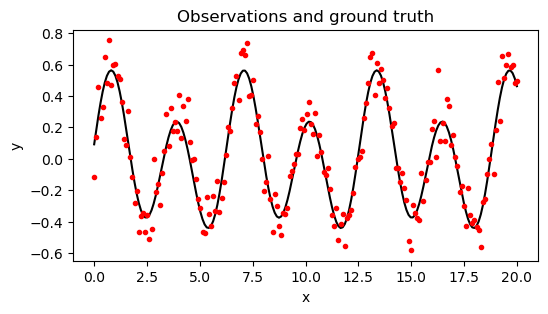

In [3]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

sigma = 0.1
n = 200
x = jnp.linspace(0, 20, n)[:, jnp.newaxis]

f_true = 0.4*jnp.sin(2*x) + 0.1*jnp.cos(x-0.4) + 0.1*jnp.sin(x)
y = f_true.squeeze() + sigma*jrnd.normal(subkey, shape=(n,))

plt.figure(figsize=(6, 3))
plt.plot(x, f_true, color='k')
plt.plot(x, y, 'r.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations and ground truth');


Set up the BaMoJax implementation:

In [4]:
LatentGP = Model('Latent Gaussian process')
lengthscale = LatentGP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = LatentGP.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
obs_noise = LatentGP.add_node(name='obs_noise', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = LatentGP.add_node(name='input', observations=x)
gp = LatentGP.add_node(name='gp', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = LatentGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=gp, scale=obs_noise))

LatentGP.print_gibbs()

Gibbs structure:
lengthscale         : p(gp | variance, lengthscale, input) p(lengthscale)
variance            : p(gp | variance, lengthscale, input) p(variance)
gp                  : p(y | gp, obs_noise) p(gp | variance, lengthscale, input)
obs_noise           : p(y | gp, obs_noise) p(obs_noise)


## SMC for a latent GP

GP inference is quicker and more robust with SMC than with regular MCMC. Set up the SMC loop below:

In [5]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(lengthscale=normal_random_walk,
                variance=normal_random_walk,
                obs_noise=normal_random_walk,
                gp=elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.04),
                      variance=dict(sigma=0.1),
                      obs_noise=dict(sigma=0.01),
                      gp=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(LatentGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=LatentGP, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for node in ['lengthscale', 'variance', 'obs_noise']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('SMC adaptation iterations:', n_iter)
print('Log marginal likelihood:', lml)

Acceptance rate for lengthscale: 0.494
Acceptance rate for variance: 0.590
Acceptance rate for obs_noise: 0.527
SMC adaptation iterations: 34
Log marginal likelihood: 104.98627150511723
CPU times: user 8min 23s, sys: 2.26 s, total: 8min 25s
Wall time: 8min 23s


Note that no ground truth is available for the lengthscale and output variance, but their values seem reasonable.

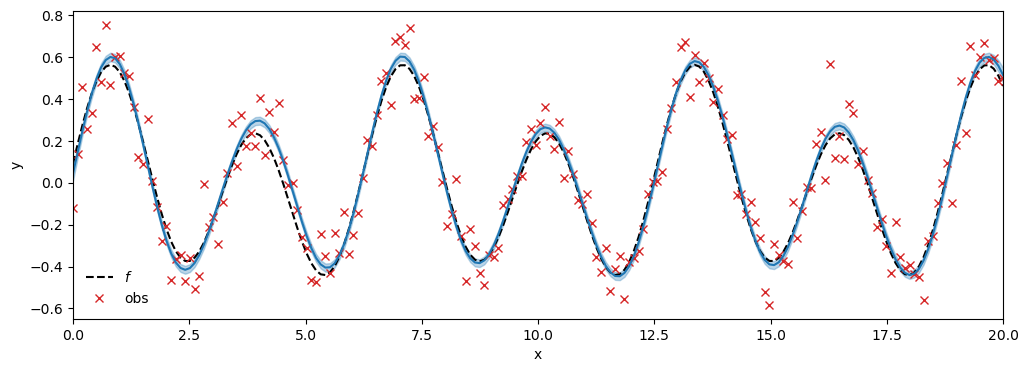

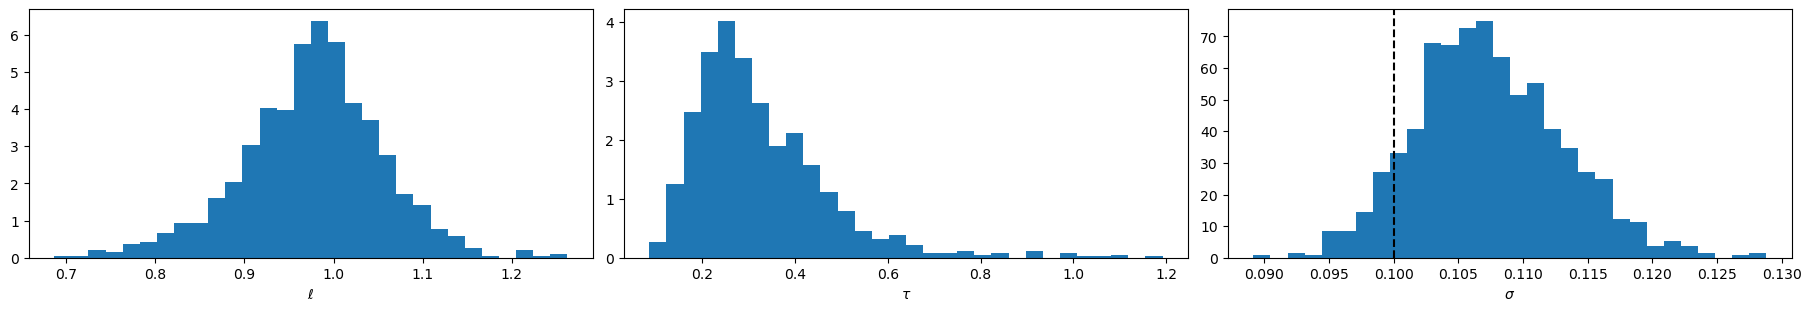

In [6]:
f_mean = jnp.mean(final_state.particles['gp'], axis=0)
f_std = jnp.std(final_state.particles['gp'], axis=0)

plt.figure(figsize=(12, 4))
plt.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
plt.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
plt.plot(jnp.squeeze(x), f_mean, color='tab:blue')
plt.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 20.])
plt.legend(frameon=False);

_, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(18, 3))

axes[0].hist(final_state.particles['lengthscale'], bins=30, density=True)
axes[0].set_xlabel(r'$\ell$');
axes[1].hist(final_state.particles['variance'], bins=30, density=True)
axes[1].set_xlabel(r'$\tau$');
axes[2].hist(final_state.particles['obs_noise'], bins=30, density=True)
axes[2].axvline(x=sigma, ls='--', color='k')
axes[2].set_xlabel(r'$\sigma$');

## Gaussian process classification



In [7]:
from sklearn.datasets import make_moons

noise = 0.2
num_obs = 200

X, Y = make_moons(noise=noise, n_samples=num_obs)
n, p = X.shape

In [8]:
def logit_link_fn(f):
    return dict(probs=jax.nn.sigmoid(f))

#
GPC = Model('Gaussian process classification')
lengthscale = GPC.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = GPC.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = GPC.add_node(name='input', observations=X)
f_node = GPC.add_node(name='f', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = GPC.add_node(name='y', distribution=dx.Bernoulli, observations=Y, parents=dict(f=f_node), link_fn=logit_link_fn)

GPC.print_gibbs()

Gibbs structure:
lengthscale         : p(f | variance, lengthscale, input) p(lengthscale)
variance            : p(f | variance, lengthscale, input) p(variance)
f                   : p(y | f) p(f | variance, lengthscale, input)


In [9]:
%%time

num_mcmc_steps = 100
num_particles = 1_000

step_fns = dict(lengthscale=normal_random_walk,
                variance=normal_random_walk,
                f=elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.03),
                      variance=dict(sigma=3.0),
                      f=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(GPC, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, lml, n_iter, final_info = smc_inference_loop(subkey, model=GPC, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for node in ['lengthscale', 'variance']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale: 0.227
Acceptance rate for variance: 0.634
CPU times: user 4min 26s, sys: 969 ms, total: 4min 27s
Wall time: 4min 23s


In [10]:
def predictive_gp_wrapper(key: Array, gp_node: Node, particle: Array, x_pred: Array):    
    gp_dist = gp_node.get_distribution(particle)
    f_pred = gp_dist.sample_predictive_batched(key, x_pred=x_pred, f=particle['f'], num_batches=20)
    return f_pred

#
num_x, num_y = 40, 40
xv, yv = jnp.meshgrid(jnp.linspace(-2.0, 3.0, num=num_x), jnp.linspace(-2.0, 3.0, num=num_y))
xpred = jnp.vstack([xv.flatten(), yv.flatten()]).T
keys = jrnd.split(key, num_particles)
particle_in_axes = jax.tree_util.tree_map(lambda l: 0, final_state.particles)
f_pred = jax.vmap(predictive_gp_wrapper, in_axes=(0, None, particle_in_axes, None))(keys, GPC.nodes['f'], final_state.particles, xpred)

p_pred = jax.nn.sigmoid(f_pred.reshape(-1, num_x, num_y))

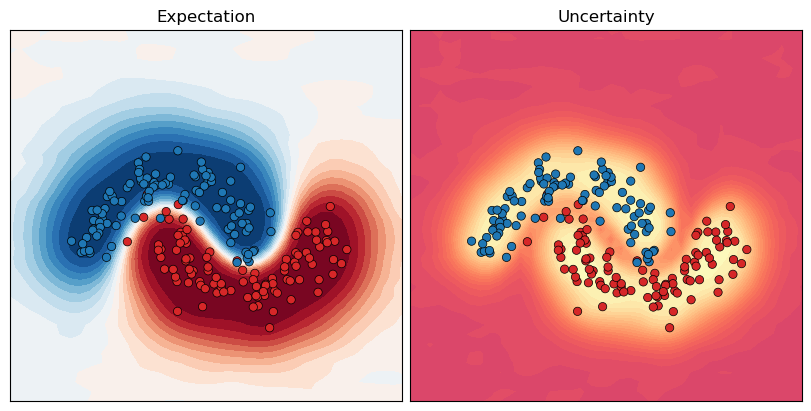

In [11]:
def plot_double_moon_fit(xgrid, logit, levels=20):
    xv, yv = xgrid
    data_colors = ["tab:red" if yn==1 else "tab:blue" for yn in Y]
    
    _, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(8, 4))
    
    mu = jnp.mean(logit, axis=0)
    sigma = jnp.std(logit, axis=0)
    axes[0].contourf(xv, yv, mu, zorder=0, cmap="RdBu_r", vmin=0.0, vmax=1.0, levels=levels)
    axes[1].contourf(xv, yv, sigma, zorder=0, cmap="magma_r", vmin=0.0, vmax=1.0, levels=levels)

    axes[0].set_title('Expectation')
    axes[1].set_title('Uncertainty')

    for ax in axes.flatten():
        ax.scatter(*X.T, c=data_colors, zorder=1, linewidths=0.5, edgecolors='k')
        ax.set_xticks([])
        ax.set_yticks([])

#

plot_double_moon_fit((xv, yv), p_pred)

The shapes of the expectation and the uncertainty nicely follow the data distributions. 

# The heteroskedastic GP

In the heteroskedastic GP, the observation noise itself is assumed to depend on the input. We model both the mean and the observation noise using Gaussian processes. Since the observation noise is the standard deviation of the Gaussian distribution, it cannot be negative so we use an exponential transformation as link function.

Text(0, 0.5, '$\\sigma$')

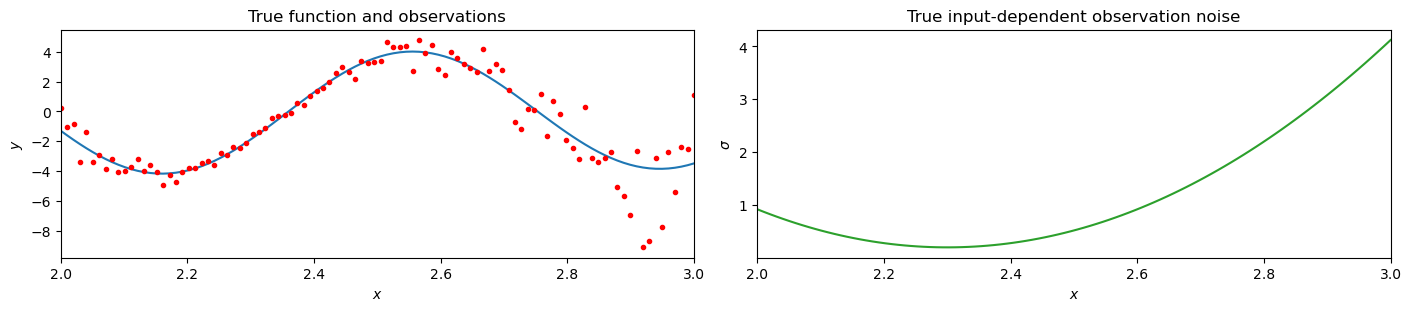

In [12]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

n = 100
x = jnp.linspace(2, 3, n)[:, jnp.newaxis]

f_true = 4*jnp.sin(8*x) + 0.1*jnp.cos(2*x-0.4) + 0.1*jnp.sin(5*x)
g_true = 8*(x-2.3)**2+0.2

y = f_true.squeeze() + g_true.squeeze()*jrnd.normal(subkey, shape=(n,))

_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, constrained_layout=True, figsize=(14, 3))

axes[0].plot(x, f_true)
axes[0].plot(x, y, '.', color='r')
axes[0].set_title('True function and observations')
axes[1].plot(x, g_true, color='tab:green')
axes[1].set_title('True input-dependent observation noise')
for ax in axes:
    ax.set_xlabel(r'$x$')
    ax.set_xlim([2., 3.])
axes[0].set_ylabel(r'$y$')
axes[1].set_ylabel(r'$\sigma$')

In [13]:
HSGP = Model('Heteroskedastic Gaussian process')
x_node = HSGP.add_node(name='input', observations=x)

lengthscale_f = HSGP.add_node(name='lengthscale_f', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance_f = HSGP.add_node(name='variance_f', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
lengthscale_g = HSGP.add_node(name='lengthscale_g', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance_g = HSGP.add_node(name='variance_g', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))

g = HSGP.add_node(name='g', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale_g, 
                                    variance=variance_g))
f = HSGP.add_node(name='f', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale_f, 
                                    variance=variance_f))
y_node = HSGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=f, scale=g), link_fn=lambda loc, scale: dict(loc=loc, scale=jnp.exp(scale)))

HSGP.print_gibbs()

Gibbs structure:
lengthscale_f       : p(f | variance_f, input, lengthscale_f) p(lengthscale_f)
variance_f          : p(f | variance_f, input, lengthscale_f) p(variance_f)
f                   : p(y | f, g) p(f | variance_f, input, lengthscale_f)
lengthscale_g       : p(g | lengthscale_g, input, variance_g) p(lengthscale_g)
variance_g          : p(g | input, lengthscale_g, variance_g) p(variance_g)
g                   : p(y | f, g) p(g | input, lengthscale_g, variance_g)


In [14]:
%%time

num_mcmc_steps = 300
num_particles = 1_000

step_fns = dict(lengthscale_f=normal_random_walk,
                variance_f=normal_random_walk,
                lengthscale_g=normal_random_walk,
                variance_g=normal_random_walk,
                f=elliptical_slice,
                g=elliptical_slice)

step_fn_params = dict(lengthscale_f=dict(sigma=0.005),
                      variance_f=dict(sigma=1.0),
                      lengthscale_g=dict(sigma=0.01),
                      variance_g=dict(sigma=0.7),
                      f=dict(implied_mvn_prior=True, name='elliptical_slice'),
                      g=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(HSGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, hsgp_lml, n_iter, final_info = smc_inference_loop(subkey, model=HSGP, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for gp in ['f', 'g']:
    for theta in [f'lengthscale_{gp}', f'variance_{gp}']:
        print(f'Acceptance rate for {theta}: {jnp.mean(final_info.update_info[theta].is_accepted):0.3f}')

Acceptance rate for lengthscale_f: 0.439
Acceptance rate for variance_f: 0.768
Acceptance rate for lengthscale_g: 0.504
Acceptance rate for variance_g: 0.427
CPU times: user 12min 34s, sys: 2.16 s, total: 12min 36s
Wall time: 12min 28s


Maybe add prediction of $y$ as well?

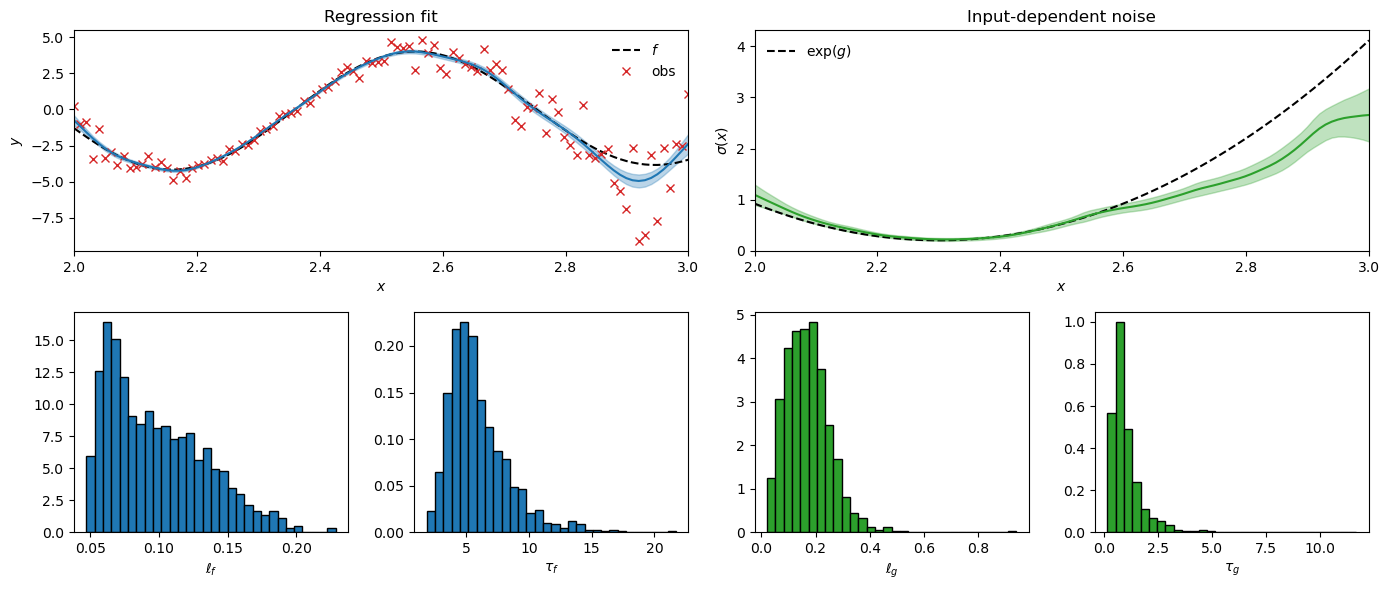

In [15]:
import matplotlib.gridspec as gridspec

f_mean = jnp.mean(final_state.particles['f'], axis=0)
f_std = jnp.std(final_state.particles['f'], axis=0)
g_transformed = jax.vmap(lambda x: jnp.exp(x), in_axes=0)(final_state.particles['g'])
g_mean = jnp.mean(g_transformed, axis=0)
g_std = jnp.std(g_transformed, axis=0)
nbins = 30

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_title('Regression fit')

ax1.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
ax1.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
ax1.plot(jnp.squeeze(x), f_mean, color='tab:blue')
ax1.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$y$')
ax1.set_xlim([2., 3.])
ax1.legend(frameon=False);

ax2 = fig.add_subplot(gs[0, 2:4])
ax2.set_title('Input-dependent noise')

ax2.plot(jnp.squeeze(x), g_true, 'k', label=r'$\text{exp}(g)$', ls='--')
ax2.plot(jnp.squeeze(x), g_mean, color='tab:green')
ax2.fill_between(jnp.squeeze(x), g_mean - 0.5*g_std, g_mean + 0.5*g_std, color='tab:green', alpha=0.3)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$\sigma(x)$')
ax2.set_xlim([2., 3.])
ax2.legend(frameon=False);

ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(final_state.particles['lengthscale_f'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:blue')
ax3.set_xlabel(r'$\ell_f$')

ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(final_state.particles['variance_f'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:blue')
ax4.set_xlabel(r'$\tau_f$')

ax5 = fig.add_subplot(gs[1, 2])
ax5.hist(final_state.particles['lengthscale_g'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:green')
ax5.set_xlabel(r'$\ell_g$')

ax6 = fig.add_subplot(gs[1, 3])
ax6.hist(final_state.particles['variance_g'].flatten(), bins=nbins, density=True, edgecolor='k', facecolor='tab:green')
ax6.set_xlabel(r'$\tau_g$')

plt.tight_layout()
plt.show()

Let's compare with a generic GP.

In [16]:
%%time

LatentGP = Model('Latent Gaussian process')
lengthscale = LatentGP.add_node(name='lengthscale', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
variance = LatentGP.add_node(name='variance', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
obs_noise = LatentGP.add_node(name='obs_noise', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
x_node = LatentGP.add_node(name='input', observations=x)
gp = LatentGP.add_node(name='gp', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = LatentGP.add_node(name='y', distribution=dx.Normal, observations=y, parents=dict(loc=gp, scale=obs_noise))


num_mcmc_steps = 300
num_particles = 1_000

step_fns = dict(lengthscale=normal_random_walk,
                variance=normal_random_walk,
                obs_noise=normal_random_walk,
                gp=elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.01),
                      variance=dict(sigma=1.0),
                      obs_noise=dict(sigma=0.1),
                      gp=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(LatentGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

final_state, lgp_lml, n_iter, final_info = smc_inference_loop(subkey, model=LatentGP, kernel=gibbs, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps)

for node in ['lengthscale', 'variance', 'obs_noise']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale: 0.155
Acceptance rate for variance: 0.775
Acceptance rate for obs_noise: 0.624
CPU times: user 4min 51s, sys: 1.09 s, total: 4min 52s
Wall time: 4min 47s


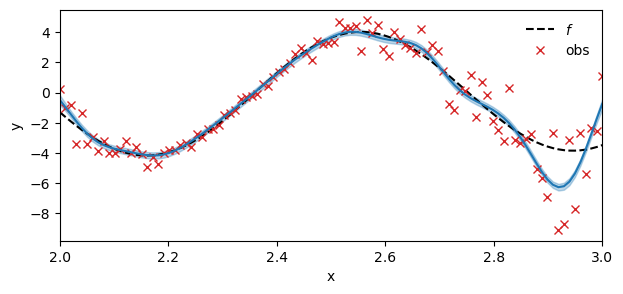

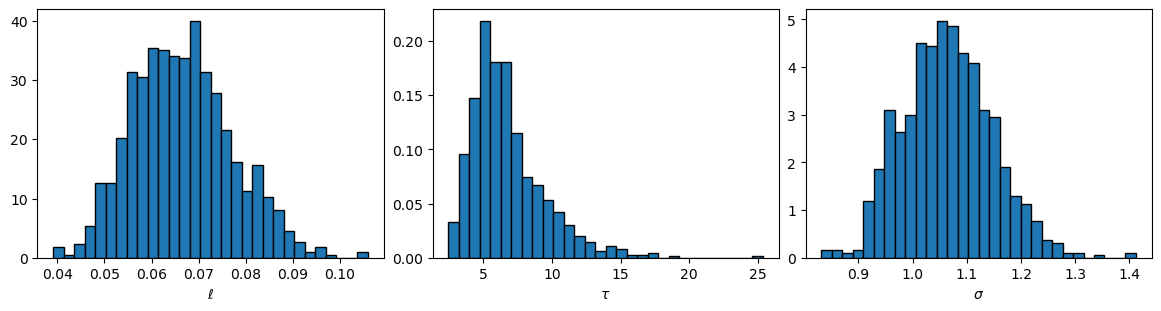

In [17]:
f_mean = jnp.mean(final_state.particles['gp'], axis=0)
f_std = jnp.std(final_state.particles['gp'], axis=0)

plt.figure(figsize=(7, 3))
plt.plot(jnp.squeeze(x), f_true, 'k', label=r'$f$', ls='--')
plt.plot(jnp.squeeze(x), y, 'x', label='obs', color='tab:red')
plt.plot(jnp.squeeze(x), f_mean, color='tab:blue')
plt.fill_between(jnp.squeeze(x), f_mean - 0.5*f_std, f_mean + 0.5*f_std, color='tab:blue', alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([2., 3.])
plt.legend(frameon=False);

_, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(11.5, 3))

axes[0].hist(final_state.particles['lengthscale'], bins=30, density=True, edgecolor='k')
axes[0].set_xlabel(r'$\ell$');
axes[1].hist(final_state.particles['variance'], bins=30, density=True, edgecolor='k')
axes[1].set_xlabel(r'$\tau$');
axes[2].hist(final_state.particles['obs_noise'], bins=30, density=True, edgecolor='k')
axes[2].set_xlabel(r'$\sigma$');

Compare marginal likelihoods: is the additional complexity of the HSGP needed here?

In [18]:
print(f'Log marginal likelihood LGP: {lgp_lml:0.3f}')
print(f'Log marginal likelihood HSGP: {hsgp_lml:0.3f}')

Log marginal likelihood LGP: -176.292
Log marginal likelihood HSGP: -141.995


Apparently so, despite the regression fit being very similar!